/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
218/218 - 5s - 24ms/step - loss: 0.0198 - val_loss: 0.0022
Epoch 2/50
218/218 - 1s - 5ms/step - loss: 0.0057 - val_loss: 0.0015
Epoch 3/50
218/218 - 1s - 5ms/step - loss: 0.0046 - val_loss: 0.0013
Epoch 4/50
218/218 - 1s - 5ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 5/50
218/218 - 1s - 5ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 6/50
218/218 - 1s - 5ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 7/50
218/218 - 1s - 5ms/step - loss: 0.0031 - val_loss: 8.1408e-04
Epoch 8/50
218/218 - 1s - 5ms/step - loss: 0.0028 - val_loss: 9.2333e-04
Epoch 9/50
218/218 - 1s - 5ms/step - loss: 0.0024 - val_loss: 7.0429e-04
Epoch 10/50
218/218 - 1s - 5ms/step - loss: 0.0024 - val_loss: 6.1901e-04
Epoch 11/50
218/218 - 1s - 5ms/step - loss: 0.0022 - val_loss: 9.1165e-04
Epoch 12/50
218/218 - 1s - 5ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 13/50
218/218 - 1s - 5ms/step - loss: 0.0021 - val_loss: 5.2892e-04
Epoch 14/50
218/218 - 1s - 5ms/step - loss: 0.0017 - val_loss: 6.6095e-04


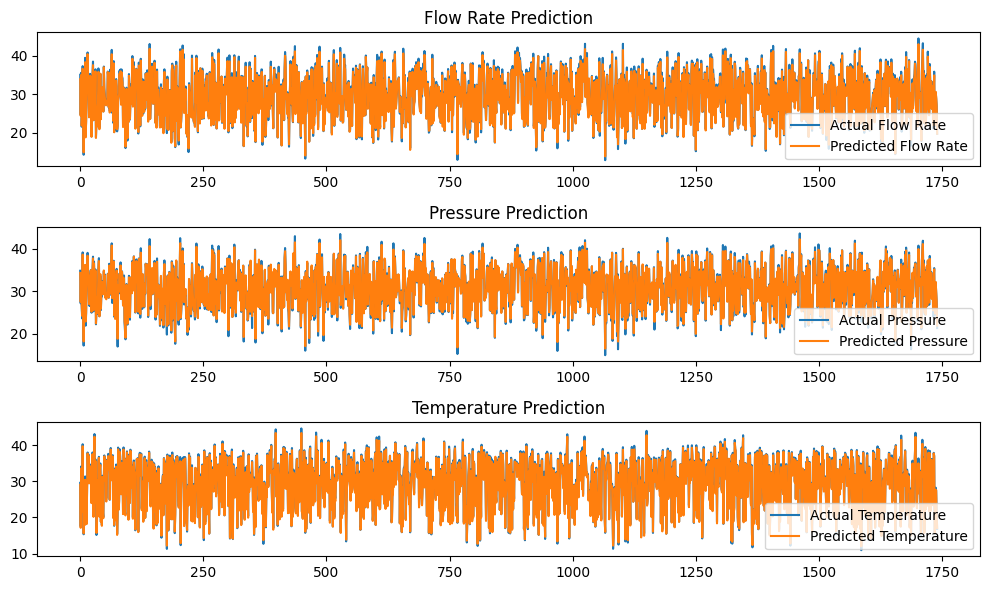

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with columns: 'Time', 'Flow Rate (m³/s)', 'Pressure (Pa)', 'Water Temperature (°C)'
df=pd.read_csv("/kaggle/input/dataset/le_bsdk.csv")
df = df.drop(columns=['Time (hours)'],axis=1) 
# df=df[['']]
target_columns = ['Flow Rate (m³/s)', 'Pressure (Pa)', 'Water Temperature (°C)']
df=df[target_columns]
# Step 1: Create lag features for the previous 48 periods
def create_lag_features(df, target_column, lag=48):
    """
    Creates lag features for the given target column.
    The lag features represent the values from the previous `lag` periods.
    """
    df_lagged = df.copy()
    for i in range(1, lag + 1):
        df_lagged[f'{target_column}_lag_{i}'] = df_lagged[target_column].shift(i)
    return df_lagged

# Define the target columns
lag = 48

# Create lag features for all target columns
df_lagged = df.copy()
for col in target_columns:
    df_lagged = create_lag_features(df_lagged, col, lag)

# Step 2: Drop rows with NaN values due to shifting
df_lagged.dropna(inplace=True)

# Step 3: Prepare the features (X) and target (y) for each variable
X = df_lagged.drop(columns=['Flow Rate (m³/s)', 'Pressure (Pa)', 'Water Temperature (°C)'])
y_flow = df_lagged['Flow Rate (m³/s)']
y_pressure = df_lagged['Pressure (Pa)']
y_temperature = df_lagged['Water Temperature (°C)']

# Step 4: Scale the data using MinMaxScaler
scaler = MinMaxScaler()

# Scale features and targets
X_scaled = scaler.fit_transform(X)

# Scale the target variables separately for flow, pressure, and temperature
y_flow_scaled = scaler.fit_transform(y_flow.values.reshape(-1, 1))
y_pressure_scaled = scaler.fit_transform(y_pressure.values.reshape(-1, 1))
y_temperature_scaled = scaler.fit_transform(y_temperature.values.reshape(-1, 1))

# Step 5: Reshape the data for LSTM (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Step 6: Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_flow_train, y_flow_test = train_test_split(X_scaled, y_flow_scaled, test_size=0.2, random_state=42)
_, _, y_pressure_train, y_pressure_test = train_test_split(X_scaled, y_pressure_scaled, test_size=0.2, random_state=42)
_, _, y_temperature_train, y_temperature_test = train_test_split(X_scaled, y_temperature_scaled, test_size=0.2, random_state=42)

# Step 7: Build and train the LSTM model for Flow Rate, Pressure, and Temperature prediction

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build models for each target (Flow Rate, Pressure, Temperature)
model_flow = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model_pressure = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model_temperature = build_lstm_model((X_train.shape[1], X_train.shape[2]))

# Train the models
model_flow.fit(X_train, y_flow_train, epochs=50, batch_size=32, validation_data=(X_test, y_flow_test), verbose=2)
model_pressure.fit(X_train, y_pressure_train, epochs=50, batch_size=32, validation_data=(X_test, y_pressure_test), verbose=2)
model_temperature.fit(X_train, y_temperature_train, epochs=50, batch_size=32, validation_data=(X_test, y_temperature_test), verbose=2)

# Step 8: Predict on the test data
y_flow_pred = model_flow.predict(X_test)
y_pressure_pred = model_pressure.predict(X_test)
y_temperature_pred = model_temperature.predict(X_test)

# Step 9: Inverse transform the predictions and true values to get them back to the original scale
y_flow_pred = scaler.inverse_transform(y_flow_pred)
y_pressure_pred = scaler.inverse_transform(y_pressure_pred)
y_temperature_pred = scaler.inverse_transform(y_temperature_pred)

y_flow_test = scaler.inverse_transform(y_flow_test)
y_pressure_test = scaler.inverse_transform(y_pressure_test)
y_temperature_test = scaler.inverse_transform(y_temperature_test)

# Step 10: Evaluate the model performance using Mean Squared Error
mse_flow = mean_squared_error(y_flow_test, y_flow_pred)
mse_pressure = mean_squared_error(y_pressure_test, y_pressure_pred)
mse_temperature = mean_squared_error(y_temperature_test, y_temperature_pred)

print(f"Mean Squared Error for Flow Rate: {mse_flow}")
print(f"Mean Squared Error for Pressure: {mse_pressure}")
print(f"Mean Squared Error for Temperature: {mse_temperature}")

# Step 11: Forecast for the next time period using the last available data
latest_data = X_scaled[-1].reshape(1, 1, -1)  # Get the most recent row of input data

next_flow_forecast = model_flow.predict(latest_data)
next_pressure_forecast = model_pressure.predict(latest_data)
next_temperature_forecast = model_temperature.predict(latest_data)

print(f"Next Flow Rate forecast: {scaler.inverse_transform(next_flow_forecast)[0][0]}")
print(f"Next Pressure forecast: {scaler.inverse_transform(next_pressure_forecast)[0][0]}")
print(f"Next Temperature forecast: {scaler.inverse_transform(next_temperature_forecast)[0][0]}")

# Step 12: Plotting actual vs predicted values for visualization (optional)
plt.figure(figsize=(10, 6))

# Plot Flow Rate
plt.subplot(3, 1, 1)
plt.plot(y_flow_test, label='Actual Flow Rate')
plt.plot(y_flow_pred, label='Predicted Flow Rate')
plt.legend()
plt.title('Flow Rate Prediction')

# Plot Pressure
plt.subplot(3, 1, 2)
plt.plot(y_pressure_test, label='Actual Pressure')
plt.plot(y_pressure_pred, label='Predicted Pressure')
plt.legend()
plt.title('Pressure Prediction')

# Plot Temperature
plt.subplot(3, 1, 3)
plt.plot(y_temperature_test, label='Actual Temperature')
plt.plot(y_temperature_pred, label='Predicted Temperature')
plt.legend()
plt.title('Temperature Prediction')

plt.tight_layout()
plt.show()
